# 📘 Drift-Aware Forecasting Evaluation with DriftMind

---

## 🎯 Objective

This notebook evaluates DriftMind's ability to forecast time series data exhibiting **concept drift**. 

We simulate dynamic signal behavior (`sin`, `cos`, `tan`) and feed it to the forecaster one point at a time, retrieving predictions immediately after each update.

---

## 🧪 1. Synthetic Dataset with Concept Drift

We generate a synthetic dataset consisting of:

- `Sin`, `Cos`, and `Tan` values  
- 3 segments, each with different amplitude and frequency  
- Designed to simulate **realistic concept drift**  
- Optional Gaussian noise  

The tangent signal is clipped to avoid explosive values.

---

## 📡 2. Feeding Data to DriftMind

Each row of the dataset is sent to the DriftMind REST API as a dictionary of **1-element arrays**, for example:

{
"Sin": [0.5],
"Cos": [0.2],
"Tan": [-0.1]
}

After each `PATCH` request, a `GET` request is sent to retrieve a prediction.

---

## 🔄 3. Forecast Retrieval

Forecasts are retrieved via the `/predict` endpoint.

If available, the response includes:

- `predictions`  
- `upperConfidence`, `lowerConfidence`  
- `anomalyScore` (optional)  
- `forecastingMethod`  

If the API returns **204 No Content**, we skip that step.

---

## 📦 4. Storing Results

We store actual vs. predicted values using the following structure:

results = {
"Sin": [{"expected": ..., "predicted": ..., "timestamp": ...}],
"Cos": [...],
"Tan": [...]
}


Only successful predictions are logged.

---

## 📊 5. Visualization

We generate a line plot for each variable:

- **Actual** values → solid line  
- **Predicted** values → dashed line  

This allows visual assessment of DriftMind’s accuracy over time, especially across drift boundaries.


![Alt text](results.png)


---

## 🧠 6. Observations

- Forecasts begin only after enough data has been fed  
- Predictions generally follow the trend but may smooth or lag during sharp transitions  
- `Tan` predictions may be noisier due to clipping and volatility  

---

## 🛠 7. Next Steps

- Add Mean Absolute Error (MAE) plots  
- Visualize upper/lower confidence bounds  
- Try different drift configurations  
- Replace with real-world time series (e.g., sensor readings, system logs)

---



🔗 Learn more about DriftMind: [https://thingbook.io](https://thingbook.io)

📁 Repository: [thingbookio/driftmind-experiments](https://github.com/thingbookio/driftmind-experiments)


In [2]:
# Load Credentials
import os

def load_driftmind_credentials(filepath="../resources/DRIFTMIND_CONNECT.txt"):
    credentials = {}
    with open(filepath, "r") as file:
        for line in file:
            if "=" in line:
                key, value = line.strip().split("=", 1)
                credentials[key.strip()] = value.strip()
    return credentials

# Load the credentials
creds = load_driftmind_credentials()
api_key = creds.get("DRIFTMIND_API_KEY")
base_url = creds.get("DRIFTMIND_API_URL")

# Optional: print to confirm (just for dev, remove before pushing)
print("API key loaded:", bool(api_key))
print("Base URL:", base_url)


API key loaded: True
Base URL: http://localthingbook.io:32081/access/api/driftmind/


In [3]:
# Create a new forecaster   
import os
import json
import requests

# Request payload
forecaster_payload = {
    "forecasterName": "Basic Forecaster Creation",
    "features": ["Sin", "Cos", "Tan"],
    "inputSize": 15,
    "outputSize": 1
}

# Send POST request to create the forecaster
response = requests.post(
    url=base_url,
    headers={
        "Content-Type": "application/json",
        "accept": "application/json",
        "Auth": api_key
    },
    json=forecaster_payload
)

# Handle response
if response.status_code == 201:
    result = response.json()
    forecaster_id = result.get("forecaster_id")
    print(f"✅ Forecaster created successfully. ID: {forecaster_id}")
else:
    print("❌ Failed to create forecaster")
    print("Status Code:", response.status_code)
    print("Response Text:", response.text)


✅ Forecaster created successfully. ID: c339beb7-ae9b-4f3e-bb73-e4d4245cb507


In [4]:
# Validate that the forecaster exists and fetch details
def get_forecaster_details(forecaster_id):
    url = f"{base_url}forecaster/{forecaster_id}/details"
    response = requests.get(
        url,
        headers={
            "accept": "application/json",
            "Auth": api_key
        }
    )
    
    if response.status_code == 200:
        details = response.json()
        print("✅ Forecaster is available.")
        print("Forecaster ID:", forecaster_id)
        print("Forecaster Name:", details.get("forecasterName"))
        print("Features:", details.get("features"))
        print("Starting Point:", details.get("properities", {}).get("initializationDate"))  # Also inside "properities"
        print("Properties:")
        for k, v in details.get("properities", {}).items():
            print(f"  {k}: {v}")
        return details
    else:
        print("❌ Could not fetch forecaster details")
        print("Status Code:", response.status_code)
        print("Response:", response.text)
        return None

# Call the function using the forecaster_id from the previous cell
forecaster_details = get_forecaster_details(forecaster_id)


✅ Forecaster is available.
Forecaster ID: c339beb7-ae9b-4f3e-bb73-e4d4245cb507
Forecaster Name: Basic Forecaster Creation
Features: ['Tan', 'Sin', 'Cos']
Starting Point: 22-09-2025 10:09:21
Properties:
  fitRate: 1
  initializationDate: 22-09-2025 10:09:21
  maxClustersAllowed: 100
  dateFormat: dd-MM-yyyy HH:mm:ss
  similarityThreshold: 0.8
  timeStampIntervalInSeconds: 60
  outputSize: 1
  inputSize: 15


In [5]:
#generate synthetic dataset
import numpy as np
import pandas as pd

def generate_sin_cos_tan_with_drifts(n=600, noise_std=0.0, seed=42):
    rng = np.random.default_rng(seed)
    t = np.arange(n)

    s1, s2 = n // 3, 2 * n // 3

    cfg = [
        dict(sin_amp=1.0, sin_freq=0.020, cos_amp=0.6, cos_freq=0.030, tan_amp=0.2, tan_freq=0.006),
        dict(sin_amp=1.8, sin_freq=0.045, cos_amp=0.3, cos_freq=0.015, tan_amp=0.35, tan_freq=0.012),
        dict(sin_amp=0.8, sin_freq=0.010, cos_amp=1.2, cos_freq=0.050, tan_amp=0.5, tan_freq=0.004),
    ]

    sin_vals = np.zeros(n, dtype=float)
    cos_vals = np.zeros(n, dtype=float)
    tan_vals = np.zeros(n, dtype=float)

    def seg_slice(i):
        if i < s1: return 0
        if i < s2: return 1
        return 2

    for i in range(n):
        c = cfg[seg_slice(i)]
        sin_vals[i] = c["sin_amp"] * np.sin(2 * np.pi * c["sin_freq"] * i)
        cos_vals[i] = c["cos_amp"] * np.cos(2 * np.pi * c["cos_freq"] * i)
        tan_arg = 2 * np.pi * c["tan_freq"] * i
        tv = c["tan_amp"] * np.tan(tan_arg)
        tan_vals[i] = np.clip(tv, -3.0, 3.0)

    if noise_std > 0:
        sin_vals += rng.normal(0, noise_std, size=n)
        cos_vals += rng.normal(0, noise_std, size=n)
        tan_vals += rng.normal(0, noise_std, size=n)

    df = pd.DataFrame({
        "Sin": sin_vals,
        "Cos": cos_vals,
        "Tan": tan_vals
    })

    return df

# Generate the dataset
df = generate_sin_cos_tan_with_drifts()


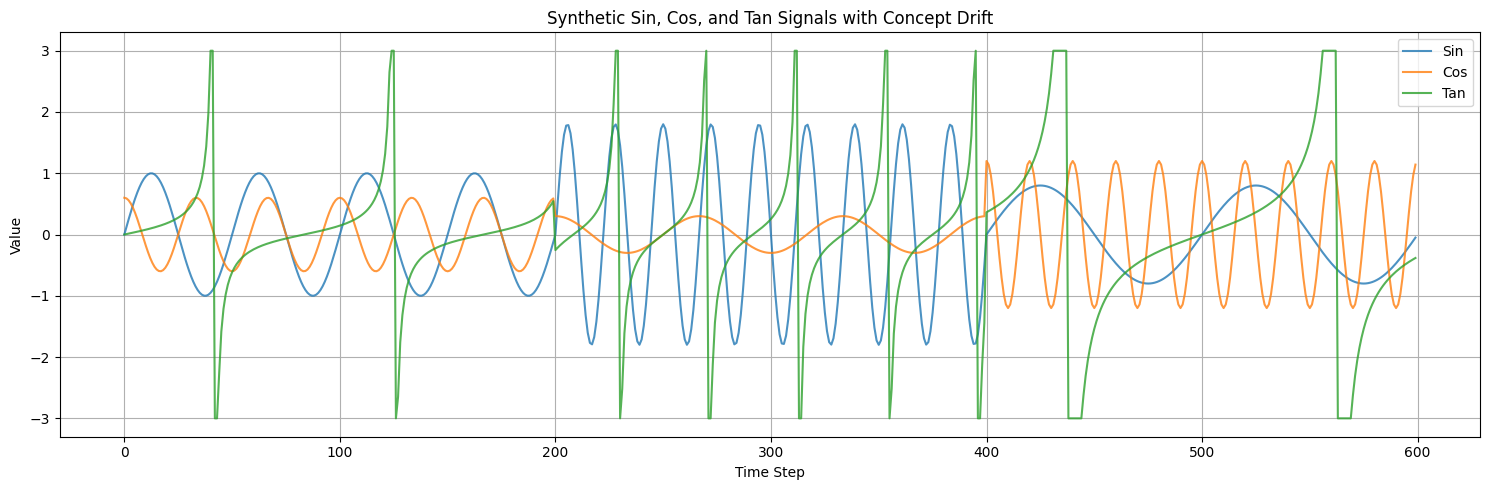

In [6]:
# Visualize sintetic dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df["Sin"], label="Sin", alpha=0.8)
plt.plot(df["Cos"], label="Cos", alpha=0.8)
plt.plot(df["Tan"], label="Tan", alpha=0.8)
plt.title("Synthetic Sin, Cos, and Tan Signals with Concept Drift")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import time

results = {
    "Sin": [],
    "Cos": [],
    "Tan": []
}

def feed_point(forecaster_id, data_point):
    payload = {
        "forecasterId": forecaster_id,
        "data": data_point
    }

    response = requests.patch(
        url=base_url,
        headers={
            "Content-Type": "application/json",
            "accept": "application/json",
            "Auth": api_key
        },
        json=payload
    )

    return response.status_code == 200


def forecast_with_forecaster():
    url = f"{base_url}forecaster/{forecaster_id}/predict"
    response = requests.get(
        url,
        headers={
            "accept": "application/json",
            "Auth": api_key
        }
    )

    if response.status_code == 200:
        return response.json()
    elif response.status_code == 204:
        return None
    else:
        print("❌ Forecast request failed")
        print("Status Code:", response.status_code)
        print("Response:", response.text)
        return None


# Step 1: Iterate row by row, feed and forecast
for idx, row in df.iterrows():
    data_point = {
        "Sin": [float(row["Sin"])],
        "Cos": [float(row["Cos"])],
        "Tan": [float(row["Tan"])]
    }

    sent = feed_point(forecaster_id, data_point)

    if not sent:
        print(f"❌ Failed to feed data at index {idx}")
        continue

   
    forecast = forecast_with_forecaster()

    if forecast:
        for var in ["Sin", "Cos", "Tan"]:
            pred = forecast.get(var, {}).get("predictions", [])
            if pred:
                results[var].append({
                    "expected": float(row[var]),
                    "predicted": float(pred[0]),
                    "timestamp": idx
                })
    else:
        print(f"⏳ No prediction available at index {idx} — waiting for model readiness.")


⏳ No prediction available at index 0 — waiting for model readiness.
⏳ No prediction available at index 1 — waiting for model readiness.
⏳ No prediction available at index 2 — waiting for model readiness.
⏳ No prediction available at index 3 — waiting for model readiness.
⏳ No prediction available at index 4 — waiting for model readiness.
⏳ No prediction available at index 5 — waiting for model readiness.
⏳ No prediction available at index 6 — waiting for model readiness.
⏳ No prediction available at index 7 — waiting for model readiness.
⏳ No prediction available at index 8 — waiting for model readiness.
⏳ No prediction available at index 9 — waiting for model readiness.
⏳ No prediction available at index 10 — waiting for model readiness.
⏳ No prediction available at index 11 — waiting for model readiness.
⏳ No prediction available at index 12 — waiting for model readiness.
⏳ No prediction available at index 13 — waiting for model readiness.
⏳ No prediction available at index 14 — wait

In [8]:
#Visualize results
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(df, variable_name):
    if df.empty:
        print(f"No data to plot for {variable_name}")
        return
    
    plt.figure(figsize=(15, 4))
    plt.plot(df["timestamp"], df["expected"], label="Actual", linewidth=2)
    plt.plot(df["timestamp"], df["predicted"], label="Predicted", linestyle='--')
    plt.title(f"{variable_name}: Actual vs Predicted")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


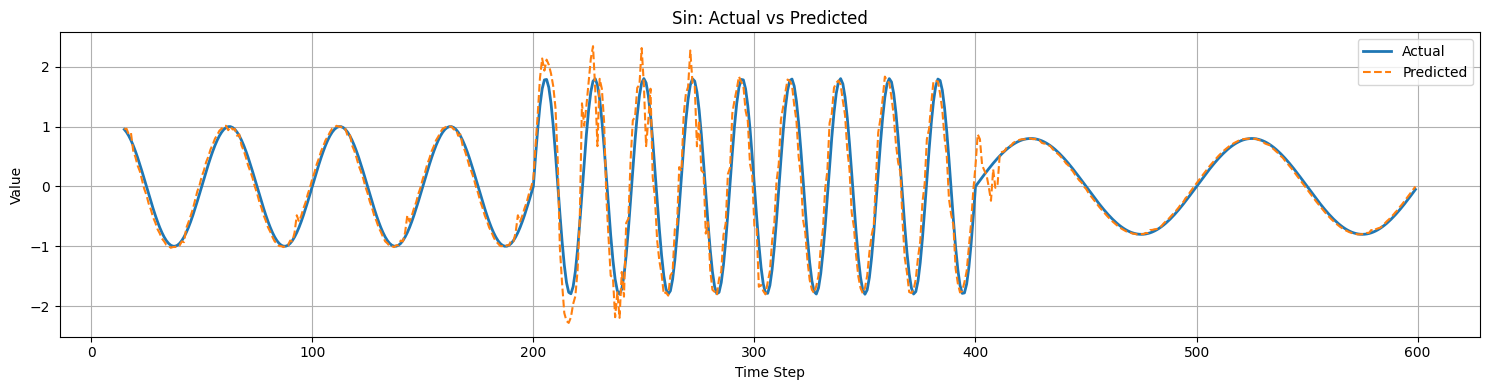

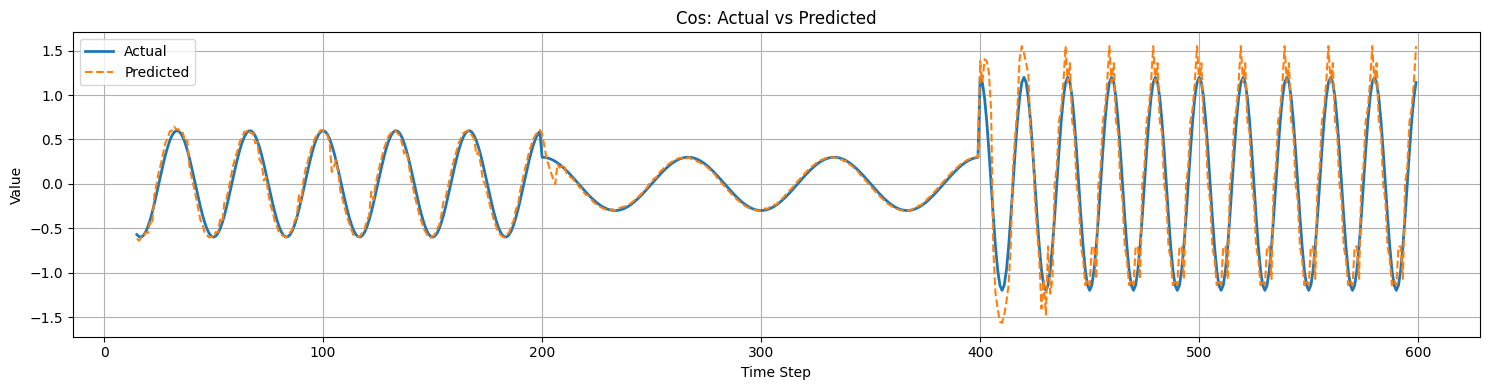

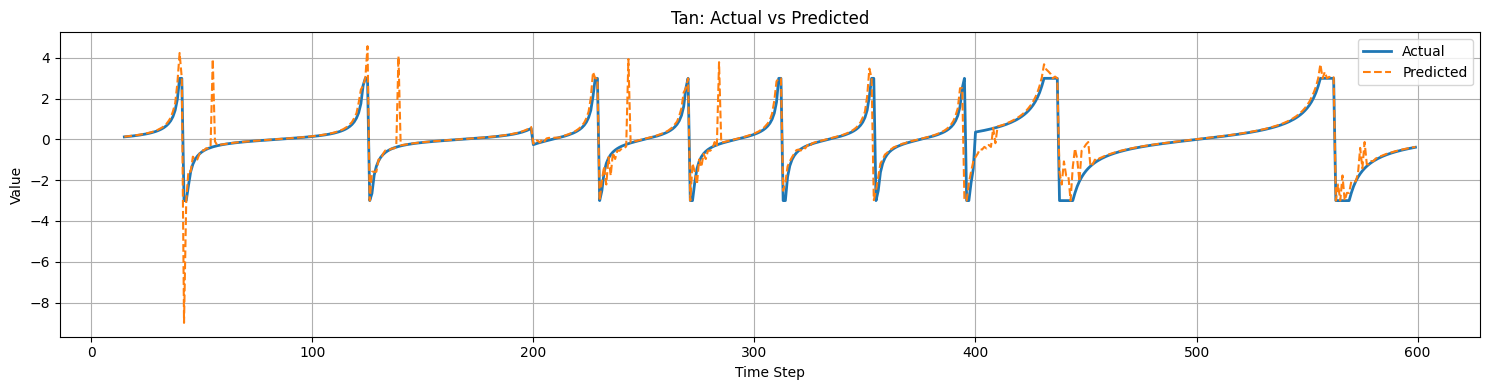

In [9]:
df_sin = pd.DataFrame(results["Sin"])
df_cos = pd.DataFrame(results["Cos"])
df_tan = pd.DataFrame(results["Tan"])

plot_actual_vs_predicted(df_sin, "Sin")
plot_actual_vs_predicted(df_cos, "Cos")
plot_actual_vs_predicted(df_tan, "Tan")


In [19]:
import pandas as pd

def get_forecaster_data(forecaster_id):
    url = f"{base_url}forecaster/{forecaster_id}/data"
    response = requests.get(
        url,
        headers={
            "accept": "application/json",
            "Auth": api_key
        }
    )

    if response.status_code == 200:
        data = response.json().get("data", {})
        if not data:
            print("ℹ️ No data available in this forecaster.")
            return None

        # Convert to a DataFrame for easier handling
        df = pd.DataFrame.from_dict(data, orient="index")
        df.index.name = "timestamp"
        df.sort_index(inplace=True)

        print(f"✅ Retrieved {len(df)} records from the forecaster.")
        display(df)

        return df
    else:
        print("❌ Failed to retrieve data")
        print("Status Code:", response.status_code)
        print("Response:", response.text)
        return None

# Call the function
df_forecaster_data = get_forecaster_data(forecaster_id)


✅ Retrieved 16 records from the forecaster.


,Tan,Sin,Cos
timestamp,,,
18-09-2025 20:12:21,-0.8335,-0.6755,0.3708
18-09-2025 20:13:21,-0.7879,-0.6472,0.0000
18-09-2025 20:14:21,-0.7458,-0.6164,-0.3708
18-09-2025 20:15:21,-0.7067,-0.5832,-0.7053
18-09-2025 20:16:21,-0.6703,-0.5476,-0.9708
18-09-2025 20:17:21,-0.6363,-0.5099,-1.1413
18-09-2025 20:18:21,-0.6044,-0.4702,-1.2000
18-09-2025 20:19:21,-0.5744,-0.4287,-1.1413
18-09-2025 20:20:21,-0.5460,-0.3854,-0.9708
